In [10]:
# Genearal usage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import scipy.stats as stats
import copy
import itertools
import math
import warnings

# model preparation and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

# dimention reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score

# LSTM
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import optuna


# 1. Problem 1

## 1.2. PROPERLY SPLIT THE DATASET AND TRAIN YOUR MODEL. PRESENT THE TRAINING HISTORY AND EVALUATE ITS PERFORMANCE. (10 POINTS)

### 1.2.1 Preprocessing

- Convert 'dteday' column into datetime.
- Add 'dy' column to represent day data.
- Set the index of the dataset in the format like '2012-12-31 20:00:00'.  Hour is added given it is realistic to assume bike sharing demand fluctuate a lot depending on the hours.
- Drop 'instant' and 'dteday' column at the end given they no longer any values in data analysis nor in bulding the predictive model.

In [2]:
bike = pd.read_csv('bike.csv')

In [3]:
# Convert 'dteday' column to datetime
bike['dteday'] = pd.to_datetime(bike['dteday'])

# Convert 'hour' column to string in the format of '00' instead of 0 for example
bike['hr'] = bike['hr'].astype(str).str.zfill(2)

# Combine 'dteday' and 'hour' columns and assign to a new column, datetime
bike['datetime'] = pd.to_datetime(bike['dteday'].astype(str) + ' ' + bike['hr'] + ':00:00')

In [4]:
# set datetime as and index
bike.set_index('datetime', inplace = True)

# convert hr column back to int64
bike['hr'] = bike['hr'].astype('int64')

In [5]:
# Insert 'dy' column between 'mnth' and 'hr' columns
bike.insert(loc = bike.columns.get_loc('hr'), column = 'dy', value = bike['dteday'].dt.day)

# drop instant column as this is an identifier and inappropriate as an input to the model
# drop dteday as this is no longer used
bike.drop('instant', axis=1, inplace=True)
bike.drop('dteday', axis=1, inplace=True)

Check autocorrelation among independent variables

Text(0.5, 1.0, 'Correlation Matrix')

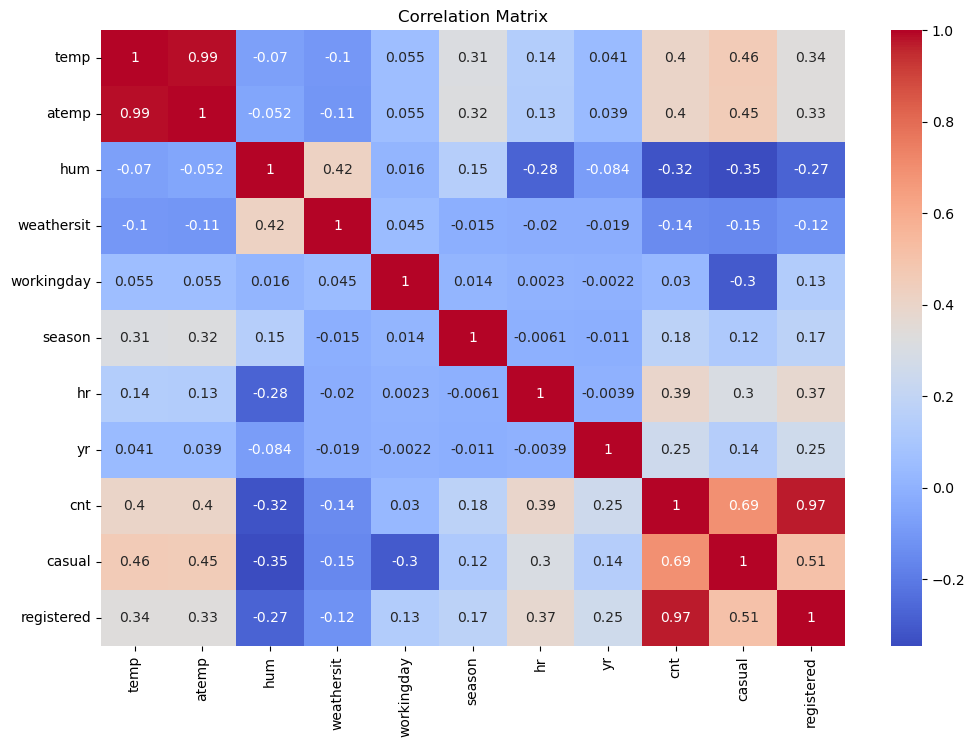

In [6]:
feature = bike[['temp','atemp','hum','weathersit','workingday','season','hr','yr','cnt','casual','registered']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(feature, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

Given 'temp' and 'atemp' are highly correlated, I drop 'atemp' from the dataset.

In [7]:
bike = bike.drop('atemp', axis=1)

In [8]:
bike.tail(4)

,season,yr,mnth,dy,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
datetime,,,,,,,,,,,,,,,
2012-12-31 20:00:00,1,1,12,31,20,0,1,1,2,0.26,0.60,0.1642,8,81,89
2012-12-31 21:00:00,1,1,12,31,21,0,1,1,1,0.26,0.60,0.1642,7,83,90
2012-12-31 22:00:00,1,1,12,31,22,0,1,1,1,0.26,0.56,0.1343,13,48,61
2012-12-31 23:00:00,1,1,12,31,23,0,1,1,1,0.26,0.65,0.1343,12,37,49


### 1.2.2. Split the dataset

Check the trend of the dataset

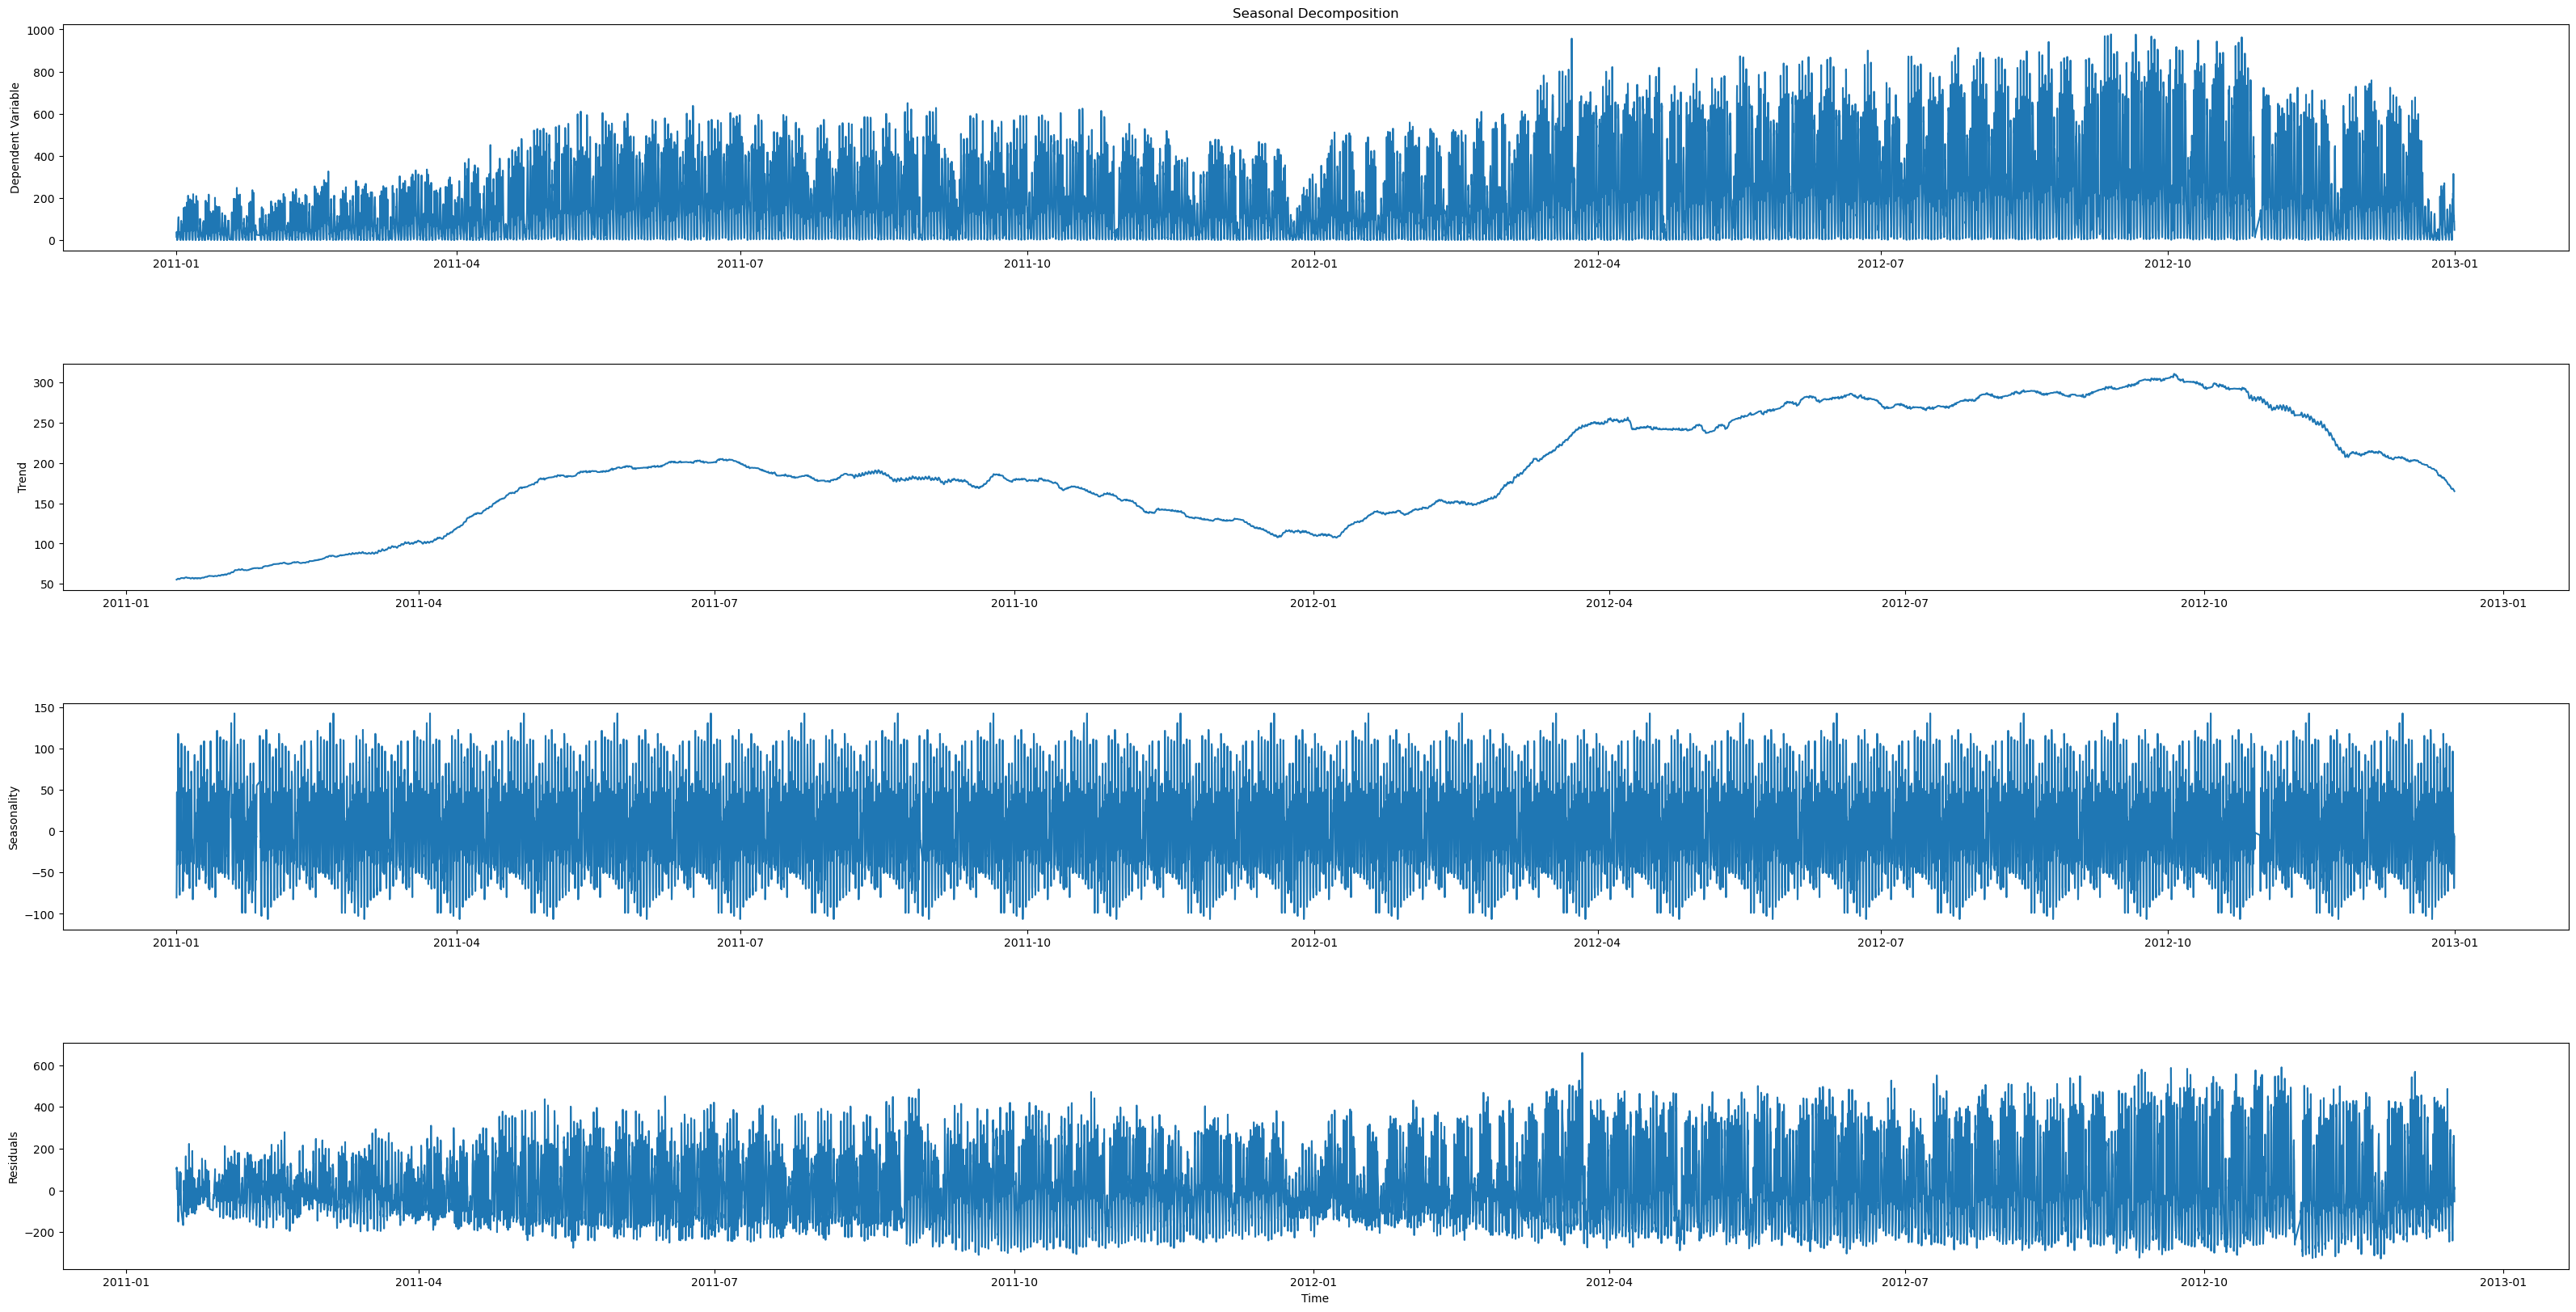

In [11]:
# Perform seasonal decomposition for monthly seasonality (24 * 30 indicates month.)
decomposition = seasonal_decompose(bike['cnt'], model='additive', period = 24*30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(40, 20))

# the original
ax1.plot(bike.index, bike['cnt'], label='Original')
ax1.set_ylabel('Dependent Variable')
ax1.set_title('Seasonal Decomposition')

# the trend
ax2.plot(decomposition.trend.index, decomposition.trend, label='Trend')
ax2.set_ylabel('Trend')

# the seasonal
ax3.plot(decomposition.seasonal.index, decomposition.seasonal, label='Seasonality')
ax3.set_ylabel('Seasonality')

# the residual
ax4.plot(decomposition.resid.index, decomposition.resid, label='Residuals')
ax4.set_ylabel('Residuals')
ax4.set_xlabel('Time')


plt.subplots_adjust(hspace=0.5)
handles, labels = ax1.get_legend_handles_labels()
plt.show()

- Given it is the time series data, data is split based on the specific timing rather than the ramdom sample picks.
- Given the data seems to have increasing trend from 2011 and 2012, it is essential to feed 2011 data as well as sufficient amount of 2012 data to train set.
- And thus, data between 2011-01-01 to 2012-06-30 is fed to the train set, and for the rest of 6 months equivalent data, the first 3 months are assigned as valid set and the rest to the test set.


In [12]:
train_data = bike[(bike['yr'] == 0) | (bike['yr'] == 1) & (bike['mnth'] <= 6)]
valid_data = bike[(bike['yr'] == 1) & (bike['mnth'] > 6) & (bike['mnth'] < 10)]
test_data = bike[(bike['yr'] == 1) & (bike['mnth'] > 9)]

In [13]:
assert train_data.shape[0] + valid_data.shape[0] + test_data.shape[0] == bike.shape[0]

Since the 'casual' and 'registered' columns are subsets of the 'cnt' column and I assume that casual and registered users behave differently, <br>
I will take an approarch where each columns are predicted separately and added together in the end to predic 'cnt' column.

Considering the above, three types of split data are introduced:
- 1. Casual: Predicting 'casual' and then summing it up with the projected 'registered' to find 'cnt'.
- 2. Registered: Predicting 'registered' and then summing it up with the projected 'casual' to find 'cnt'.
- 3. Cnt: for assessing the loss of the prediction model using 1.2.

In [14]:
# 1. casual
X_train_c = train_data.drop(['cnt','casual','registered'], axis=1)
y_train_c = train_data['casual']

X_valid_c = valid_data.drop(['cnt','casual','registered'], axis=1)
y_valid_c = valid_data['casual']

X_test_c = test_data.drop(['cnt','casual','registered'], axis=1)
y_test_c = test_data['casual']

In [15]:
# 2. registered
X_train_r = train_data.drop(['cnt','casual','registered'], axis=1)
y_train_r = train_data['registered']

X_valid_r = valid_data.drop(['cnt','casual','registered'], axis=1)
y_valid_r = valid_data['registered']

X_test_r = test_data.drop(['cnt','casual','registered'], axis=1)
y_test_r = test_data['registered']

In [16]:
# 3. cnt
y_train = train_data['cnt']
y_valid = valid_data['cnt']
y_test = test_data['cnt']

### 1.2.3. train LSTM model

#### 1.2.3.1 casual

In [17]:
# Define the model architecture
model_LSTM_c = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_c.shape[1],)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_LSTM_c.compile(optimizer = optimizer, 
                   loss='mean_squared_error')

# Create a ModelCheckpoint callback to save the best model weights
checkpoint_c = ModelCheckpoint('model_c_weights.h5', 
                               monitor='val_loss',  
                               save_best_only=True,  
                               mode='min', 
                               verbose=0)

# Fit the model to the training data
model_LSTM_c.fit(X_train_c, y_train_c, 
               epochs=100, 
               batch_size=24*5, 
               validation_data=(X_valid_c, y_valid_c),
               callbacks=[checkpoint_c]) 

Epoch 1/100
109/109 [==============================] - 4s 10ms/step - loss: 3039.7642 - val_loss: 6532.2666
Epoch 2/100
 10/109 [=>............................] - ETA: 0s - loss: 2588.4807

c:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


109/109 [==============================] - 1s 7ms/step - loss: 2557.0903 - val_loss: 5860.7363
Epoch 3/100
109/109 [==============================] - 1s 9ms/step - loss: 2013.5011 - val_loss: 4412.3438
Epoch 4/100
109/109 [==============================] - 1s 9ms/step - loss: 1522.6074 - val_loss: 2845.5491
Epoch 5/100
109/109 [==============================] - 1s 12ms/step - loss: 1139.9675 - val_loss: 1723.8134
Epoch 6/100
109/109 [==============================] - 1s 11ms/step - loss: 872.3956 - val_loss: 1950.3899
Epoch 7/100
109/109 [==============================] - 1s 6ms/step - loss: 701.1835 - val_loss: 1258.1334
Epoch 8/100
109/109 [==============================] - 1s 9ms/step - loss: 632.8424 - val_loss: 1133.5635
Epoch 9/100
109/109 [==============================] - 1s 11ms/step - loss: 606.9797 - val_loss: 1057.7106
Epoch 10/100
109/109 [==============================] - 1s 7ms/step - loss: 566.0703 - val_loss: 1120.8661
Epoch 11/100
109/109 [============================

In [18]:
# prediction
train_c_pred = model_LSTM_c.predict(X_train_c.values)
valid_c_pred = model_LSTM_c.predict(X_valid_c.values)
test_c_pred = model_LSTM_c.predict(X_test_c.values)

# predicted result
train_c_MAPE_lstm = mean_absolute_percentage_error(y_train_c, train_c_pred)
valid_c_MAPE_lstm = mean_absolute_percentage_error(y_valid_c, valid_c_pred)
test_c_MAPE_lstm = mean_absolute_percentage_error(y_test_c, test_c_pred)

print('train(casual) MAPE: ', train_c_MAPE_lstm)
print('valid(casual) MAPE: ', valid_c_MAPE_lstm)
print('test(casual) MAPE: ', test_c_MAPE_lstm)

68/68 [==============================] - 0s 2ms/step
train(casual) MAPE:  1614839119636911.8
valid(casual) MAPE:  918498130286859.6
test(casual) MAPE:  1691736906251744.2


#### 1.2.3.2. Registered

In [20]:
# Define the model architecture
model_LSTM_r = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_r.shape[1],)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_LSTM_r.compile(optimizer = optimizer, 
                   loss='mean_squared_error')

# Create a ModelCheckpoint callback to save the best model weights
checkpoint_r = ModelCheckpoint('model_r_weights.h5', 
                               monitor='val_loss',  
                               save_best_only=True,  
                               mode='min', 
                               verbose=0)

# Fit the model to the training data
model_LSTM_r.fit(X_train_r, y_train_r, 
               epochs=100, 
               batch_size=24*5, 
               validation_data=(X_valid_r, y_valid_r),
               callbacks=[checkpoint_r]) 

Epoch 1/100
109/109 [==============================] - 5s 8ms/step - loss: 35063.8477 - val_loss: 88659.0625
Epoch 2/100
 23/109 [=====>........................] - ETA: 0s - loss: 33797.1719

c:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


109/109 [==============================] - 1s 7ms/step - loss: 33490.7461 - val_loss: 84392.9531
Epoch 3/100
109/109 [==============================] - 1s 11ms/step - loss: 31433.8633 - val_loss: 75688.5547
Epoch 4/100
109/109 [==============================] - 1s 6ms/step - loss: 28974.0293 - val_loss: 69065.9375
Epoch 5/100
109/109 [==============================] - 2s 16ms/step - loss: 26237.7090 - val_loss: 68695.0312
Epoch 6/100
109/109 [==============================] - 1s 10ms/step - loss: 23328.2617 - val_loss: 57276.2461
Epoch 7/100
109/109 [==============================] - 1s 10ms/step - loss: 20481.8340 - val_loss: 56013.5508
Epoch 8/100
109/109 [==============================] - 1s 6ms/step - loss: 17543.5508 - val_loss: 46219.7617
Epoch 9/100
109/109 [==============================] - 2s 15ms/step - loss: 14894.7080 - val_loss: 45602.8555
Epoch 10/100
109/109 [==============================] - 1s 7ms/step - loss: 12463.5684 - val_loss: 35569.3984
Epoch 11/100
109/109 [===

In [21]:
# prediction
train_r_pred = model_LSTM_r.predict(X_train_r.values)
valid_r_pred = model_LSTM_r.predict(X_valid_r.values)
test_r_pred = model_LSTM_r.predict(X_test_r.values)

# predicted result
train_r_MAPE_lstm = mean_absolute_percentage_error(y_train_r, train_r_pred)
valid_r_MAPE_lstm = mean_absolute_percentage_error(y_valid_r, valid_r_pred)
test_r_MAPE_lstm = mean_absolute_percentage_error(y_test_r, test_r_pred)

print('train(registered) MAPE: ', train_r_MAPE_lstm)
print('valid(registered) MAPE: ', valid_r_MAPE_lstm)
print('test(registered) MAPE: ', test_r_MAPE_lstm)

68/68 [==============================] - 0s 2ms/step
train(registered) MAPE:  65615025745169.336
valid(registered) MAPE:  0.43841742496817065
test(registered) MAPE:  23121068917099.496


#### 1.2.3.3. Combined result

train ( y vs yhat(casual_pred + register_pred) )

In [22]:
combined_result_train = y_train.copy()

combined_result_train = pd.DataFrame(combined_result_train).join(pd.DataFrame(train_c_pred, index = y_train.index))
combined_result_train = combined_result_train.rename(columns={'cnt': 'cnt', 0: 'casual_pred'})

combined_result_train = combined_result_train.join(pd.DataFrame(train_r_pred, index = y_train.index))
combined_result_train = combined_result_train.rename(columns={'cnt': 'cnt', 'casual_pred': 'casual_pred', 0: 'registered_pred'})

combined_result_train['cnt_pred'] = round(combined_result_train['casual_pred'] + combined_result_train['registered_pred'],0)
combined_result_train

,cnt,casual_pred,registered_pred,cnt_pred
datetime,,,,
2011-01-01 00:00:00,16,7.706887,41.051491,49.0
2011-01-01 01:00:00,40,2.833287,27.691196,31.0
2011-01-01 02:00:00,32,0.015468,9.970799,10.0
2011-01-01 03:00:00,13,0.175824,4.272127,4.0
2011-01-01 04:00:00,1,0.457782,5.018802,5.0
...,...,...,...,...
2012-06-30 19:00:00,374,175.626282,242.701370,418.0
2012-06-30 20:00:00,292,151.922913,208.544083,360.0
2012-06-30 21:00:00,213,113.604256,180.142166,294.0


valid ( y vs yhat(casual_pred + register_pred) )

In [23]:
combined_result_valid = y_valid.copy()

combined_result_valid = pd.DataFrame(combined_result_valid).join(pd.DataFrame(valid_c_pred, index = y_valid.index))
combined_result_valid = combined_result_valid.rename(columns={'cnt': 'cnt', 0: 'casual_pred'})

combined_result_valid = combined_result_valid.join(pd.DataFrame(valid_r_pred, index = y_valid.index))
combined_result_valid = combined_result_valid.rename(columns={'cnt': 'cnt', 'casual_pred': 'casual_pred', 0: 'registered_pred'})

combined_result_valid['cnt_pred'] = round(combined_result_valid['casual_pred'] + combined_result_valid['registered_pred'],0)
combined_result_valid

,cnt,casual_pred,registered_pred,cnt_pred
datetime,,,,
2012-07-01 00:00:00,149,35.132641,83.537552,119.0
2012-07-01 01:00:00,93,32.909103,84.953308,118.0
2012-07-01 02:00:00,90,20.857018,75.449265,96.0
2012-07-01 03:00:00,33,15.891969,55.981541,72.0
2012-07-01 04:00:00,4,6.988966,36.922546,44.0
...,...,...,...,...
2012-09-30 19:00:00,257,46.727119,122.392525,169.0
2012-09-30 20:00:00,194,35.489861,104.407112,140.0
2012-09-30 21:00:00,123,46.293800,141.535309,188.0


test ( y vs yhat(casual_pred + register_pred) )

In [24]:
combined_result_test = y_test.copy()

combined_result_test = pd.DataFrame(combined_result_test).join(pd.DataFrame(test_c_pred, index = y_test.index))
combined_result_test = combined_result_test.rename(columns={'cnt': 'cnt', 0: 'casual_pred'})

combined_result_test = combined_result_test.join(pd.DataFrame(test_r_pred, index = y_test.index))
combined_result_test = combined_result_test.rename(columns={'cnt': 'cnt', 'casual_pred': 'casual_pred', 0: 'registered_pred'})

combined_result_test['cnt_pred'] = round(combined_result_test['casual_pred'] + combined_result_test['registered_pred'],0)
combined_result_test

,cnt,casual_pred,registered_pred,cnt_pred
datetime,,,,
2012-10-01 00:00:00,45,9.861841,57.593250,67.0
2012-10-01 01:00:00,18,7.916420,28.569817,36.0
2012-10-01 02:00:00,12,7.462339,5.588157,13.0
2012-10-01 03:00:00,7,4.247800,5.525346,10.0
2012-10-01 04:00:00,10,4.657768,15.561538,20.0
...,...,...,...,...
2012-12-31 19:00:00,119,10.140220,120.680840,131.0
2012-12-31 20:00:00,89,9.318337,86.785507,96.0
2012-12-31 21:00:00,90,8.459480,93.082611,102.0


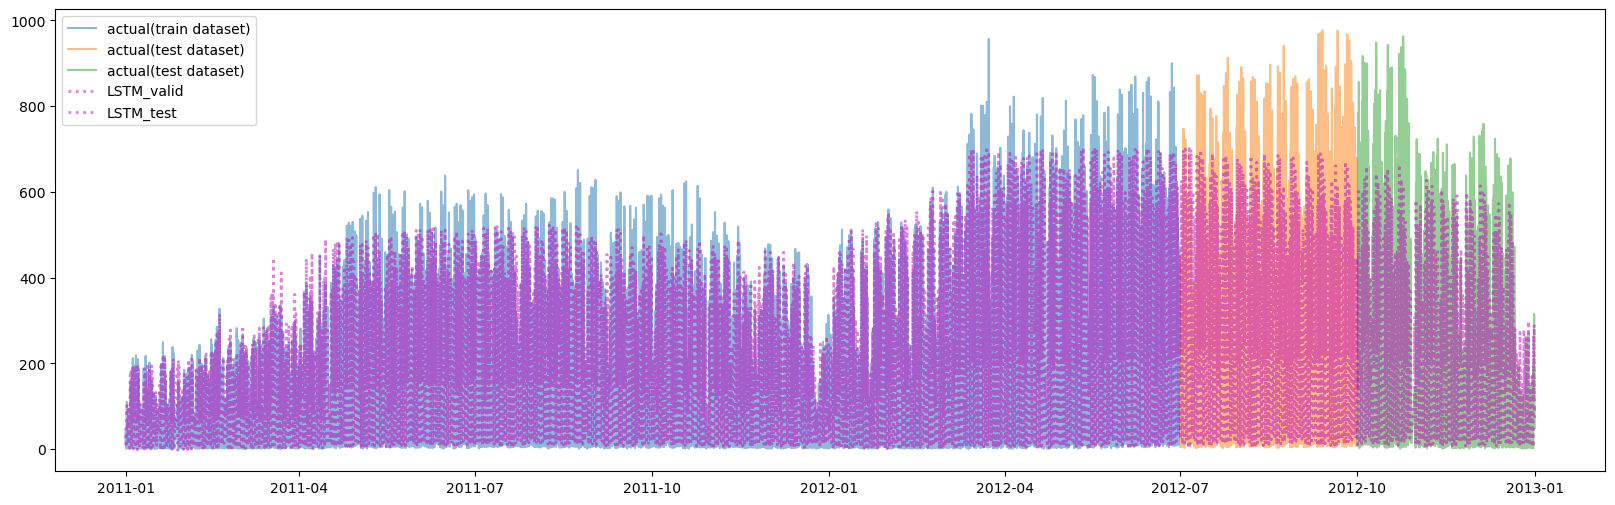

In [25]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y_train.index, y_train.values, label="actual(train dataset)", alpha = 0.5)
ax.plot(y_valid.index, y_valid.values, label="actual(test dataset)", alpha = 0.5)
ax.plot(y_test.index, y_test.values, label="actual(test dataset)", alpha = 0.5)

ax.plot(y_train.index, combined_result_train['cnt_pred'], linestyle="dotted", lw=2,color="m", alpha = 0.5)
ax.plot(y_valid.index, combined_result_valid['cnt_pred'], label="LSTM_valid", linestyle="dotted", lw=2, color="m", alpha = 0.5)
ax.plot(y_test.index, combined_result_test['cnt_pred'], label="LSTM_test", linestyle="dotted", lw=2, color="m", alpha = 0.5) 
plt.legend()

In [26]:
# predicted result
train_MAPE_lstm = mean_absolute_percentage_error(combined_result_train['cnt'], combined_result_train['cnt_pred'])
valid_MAPE_lstm = mean_absolute_percentage_error(combined_result_valid['cnt'], combined_result_valid['cnt_pred'])
test_MAPE_lstm = mean_absolute_percentage_error(combined_result_test['cnt'], combined_result_test['cnt_pred'])

print('train MAPE is {}'.format(train_MAPE_lstm))
print('valid MAPE is {}'.format(valid_MAPE_lstm))
print('test MAPE is {}'.format(test_MAPE_lstm))

train MAPE is 0.6592009095403286
valid MAPE is 0.4554081452279803
test MAPE is 0.7501862376025298


### 1.2.4. Performance Evaluation
- By looking at the visualization, the model captures the high-level time-series trend of the data.
- For the test set, the loss is more than 0.75 which suggests the model is not accurate enough.
- Another unique characteristic is the relationship between valid loss and train loss.  In this model, valid loss < train loss which may come from various possible causes such as not enough generalization to unseen data (the valid set was coincidently better fit to the trained model) or too high learning rate.

## 1.3.	HYPERPARAMETER TUNING PLAYS A CRUCIAL ROLE IN OPTIMIZING NEURAL NETWORKS. ATTEMPT TO TUNE THE HYPERPARAMETERS OF YOUR MODEL AND ANALYZE THE IMPACT ON ITS PERFORMANCE. (5 POINTS)

### 1.3.1. Tune hyperparameters

The Bayesian Optimization is being applied to tune the following hyperparameters
- number of neurons per layer
- dropout rate
- learning rate
- batch size


#### 1.3.1.1. Casual

In [58]:

def create_model(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units_1', 128, 512), activation='relu', input_shape=(X_train_c.shape[1],)))
    model.add(Dropout(trial.suggest_float('dropout_1', 0.0, 0.5)))
    model.add(BatchNormalization())
    model.add(Dense(trial.suggest_int('units_2', 64, 256), activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout_2', 0.0, 0.5)))
    model.add(BatchNormalization())
    model.add(Dense(trial.suggest_int('units_3', 32, 128), activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout_3', 0.0, 0.5)))
    model.add(BatchNormalization())
    model.add(Dense(1))

    optimizer = Adam(learning_rate=trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    model = create_model(trial)
    history = model.fit(X_train_c, y_train_c, 
                        epochs = 50, 
                        batch_size = batch_size, 
                        validation_data=(X_valid_c, y_valid_c),
                        verbose=0)
    return np.min(history.history['val_loss'])

In [59]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10) 
print(f"The best parameters are : \n {study.best_params}")

[I 2023-08-21 23:55:15,692] A new study created in memory with name: no-name-8ed03b66-1804-4b30-90d9-baaf430cffd8
[I 2023-08-21 23:55:59,863] Trial 0 finished with value: 732.3892211914062 and parameters: {'batch_size': 256, 'units_1': 442, 'dropout_1': 0.002595804557800896, 'units_2': 227, 'dropout_2': 0.08144365465161074, 'units_3': 53, 'dropout_3': 0.4993799244741601, 'learning_rate': 0.0006246220474456041}. Best is trial 0 with value: 732.3892211914062.
[I 2023-08-21 23:57:25,988] Trial 1 finished with value: 1589.8236083984375 and parameters: {'batch_size': 64, 'units_1': 507, 'dropout_1': 0.38613535822262857, 'units_2': 185, 'dropout_2': 0.37709097494199256, 'units_3': 121, 'dropout_3': 0.38874885799035797, 'learning_rate': 3.104509070284468e-05}. Best is trial 0 with value: 732.3892211914062.
[I 2023-08-21 23:58:04,352] Trial 2 finished with value: 941.446044921875 and parameters: {'batch_size': 256, 'units_1': 333, 'dropout_1': 0.09074809270403345, 'units_2': 148, 'dropout_2': 

The best parameters are : 
 {'batch_size': 256, 'units_1': 442, 'dropout_1': 0.002595804557800896, 'units_2': 227, 'dropout_2': 0.08144365465161074, 'units_3': 53, 'dropout_3': 0.4993799244741601, 'learning_rate': 0.0006246220474456041}


### 1.3.1.2. Registered

In [61]:

def create_model(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units_1', 128, 512), activation='relu', input_shape=(X_train_r.shape[1],)))
    model.add(Dropout(trial.suggest_float('dropout_1', 0.0, 0.5)))
    model.add(BatchNormalization())
    model.add(Dense(trial.suggest_int('units_2', 64, 256), activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout_2', 0.0, 0.5)))
    model.add(BatchNormalization())
    model.add(Dense(trial.suggest_int('units_3', 32, 128), activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout_3', 0.0, 0.5)))
    model.add(BatchNormalization())
    model.add(Dense(1))

    optimizer = Adam(learning_rate=trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    model = create_model(trial)
    history = model.fit(X_train_r, y_train_r, 
                        epochs=50, 
                        batch_size = batch_size, 
                        validation_data=(X_valid_r, y_valid_r),
                        verbose=0)
    return np.min(history.history['val_loss'])

In [62]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15) 
print(f"The best parameters are : \n {study.best_params}")

[I 2023-08-22 00:05:11,202] A new study created in memory with name: no-name-87a30baf-e442-471e-86f8-10c48cd2f8a5
[I 2023-08-22 00:06:22,761] Trial 0 finished with value: 14227.5537109375 and parameters: {'batch_size': 64, 'units_1': 209, 'dropout_1': 0.2405337664304661, 'units_2': 181, 'dropout_2': 0.4540020017781669, 'units_3': 107, 'dropout_3': 0.10400742611293823, 'learning_rate': 0.023533125609025377}. Best is trial 0 with value: 14227.5537109375.
[I 2023-08-22 00:07:41,431] Trial 1 finished with value: 15336.556640625 and parameters: {'batch_size': 64, 'units_1': 491, 'dropout_1': 0.47614290670453807, 'units_2': 115, 'dropout_2': 0.24900027269238334, 'units_3': 34, 'dropout_3': 0.21865006660859282, 'learning_rate': 0.0001676657337733469}. Best is trial 0 with value: 14227.5537109375.
[I 2023-08-22 00:08:36,648] Trial 2 finished with value: 90311.671875 and parameters: {'batch_size': 128, 'units_1': 502, 'dropout_1': 0.13524035630009795, 'units_2': 159, 'dropout_2': 0.216337649363

The best parameters are : 
 {'batch_size': 256, 'units_1': 411, 'dropout_1': 0.1665642242611643, 'units_2': 248, 'dropout_2': 0.1529642830518752, 'units_3': 50, 'dropout_3': 0.3703911612225602, 'learning_rate': 0.0038966960338289816}


## 1.3.2. Rebuild the model

[Casual] The best parameters are : <br>
 {'batch_size': 256, 'units_1': 442, 'dropout_1': 0.002595804557800896, 'units_2': 227, 'dropout_2': 0.08144365465161074, 'units_3': 53, 'dropout_3': 0.4993799244741601, 'learning_rate': 0.0006246220474456041}

In [72]:
# Define the model architecture
model_LSTM_c = Sequential([
    Dense(442, activation='relu', input_shape=(X_train_c.shape[1],)),
    Dropout(0.002595804557800896),
    BatchNormalization(),
    Dense(227, activation='relu'),
    Dropout(0.08144365465161074),
    BatchNormalization(),
    Dense(53, activation='relu'),
    Dropout(0.4993799244741601),
    BatchNormalization(),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.0006246220474456041)
model_LSTM_c.compile(optimizer = optimizer, 
                   loss='mean_squared_error')

# Create a ModelCheckpoint callback to save the best model weights
checkpoint_c_n = ModelCheckpoint('best_model_c_weights.h5', 
                                  monitor='val_loss',  
                                  save_best_only=True,  
                                  mode='min', 
                                  verbose=1)

# Fit the model to the training data
model_LSTM_c.fit(X_train_c, y_train_c, 
               epochs=100, 
               batch_size=256, 
               validation_data=(X_valid_c, y_valid_c),
               callbacks=[checkpoint_c_n]) 

Epoch 1/100
47/51 [==========================>...] - ETA: 0s - loss: 3046.9211
Epoch 1: val_loss improved from inf to 6804.77686, saving model to best_model_c_weights.h5
51/51 [==============================] - 4s 21ms/step - loss: 3011.0500 - val_loss: 6804.7769
Epoch 2/100
 5/51 [=>............................] - ETA: 0s - loss: 2971.7854

c:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/51 [===========================>..] - ETA: 0s - loss: 2760.6365
Epoch 2: val_loss improved from 6804.77686 to 6737.84863, saving model to best_model_c_weights.h5
51/51 [==============================] - 1s 19ms/step - loss: 2759.0786 - val_loss: 6737.8486
Epoch 3/100
49/51 [===========================>..] - ETA: 0s - loss: 2603.4526
Epoch 3: val_loss improved from 6737.84863 to 6516.14990, saving model to best_model_c_weights.h5
51/51 [==============================] - 1s 25ms/step - loss: 2592.4805 - val_loss: 6516.1499
Epoch 4/100
51/51 [==============================] - ETA: 0s - loss: 2427.9922
Epoch 4: val_loss improved from 6516.14990 to 6175.58984, saving model to best_model_c_weights.h5
51/51 [==============================] - 2s 34ms/step - loss: 2427.9922 - val_loss: 6175.5898
Epoch 5/100
49/51 [===========================>..] - ETA: 0s - loss: 2246.5288
Epoch 5: val_loss improved from 6175.58984 to 5688.40967, saving model to best_model_c_weights.h5
51/51 [===============

In [73]:
# prediction
train_c_pred = model_LSTM_c.predict(X_train_c.values)
valid_c_pred = model_LSTM_c.predict(X_valid_c.values)
test_c_pred = model_LSTM_c.predict(X_test_c.values)

# predicted result
train_c_MAPE_lstm = mean_absolute_percentage_error(y_train_c, train_c_pred)
valid_c_MAPE_lstm = mean_absolute_percentage_error(y_valid_c, valid_c_pred)
test_c_MAPE_lstm = mean_absolute_percentage_error(y_test_c, test_c_pred)

print('train(casual) MAPE: ', train_c_MAPE_lstm)
print('valid(casual) MAPE: ', valid_c_MAPE_lstm)
print('test(casual) MAPE: ', test_c_MAPE_lstm)

68/68 [==============================] - 0s 2ms/step
train(casual) MAPE:  1142662991263142.8
valid(casual) MAPE:  626486735866658.0
test(casual) MAPE:  947756690934977.2


[Registered] The best parameters are : <br>
 {'batch_size': 256, 'units_1': 411, 'dropout_1': 0.1665642242611643, 'units_2': 248, 'dropout_2': 0.1529642830518752, 'units_3': 50, 'dropout_3': 0.3703911612225602, 'learning_rate': 0.0038966960338289816}

In [65]:
# Define the model architecture
model_LSTM_r = Sequential([
    Dense(411, activation='relu', input_shape=(X_train_r.shape[1],)),
    Dropout(0.1665642242611643),
    BatchNormalization(),
    Dense(248, activation='relu'),
    Dropout(0.1529642830518752),
    BatchNormalization(),
    Dense(50, activation='relu'),
    Dropout(0.3703911612225602),
    BatchNormalization(),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.0038966960338289816)
model_LSTM_r.compile(optimizer = optimizer, 
                   loss='mean_squared_error')


# Create a ModelCheckpoint callback to save the best model weights
checkpoint_r_n = ModelCheckpoint('best_model_r_weights.h5', 
                                  monitor='val_loss',  
                                  save_best_only=True,  
                                  mode='min', 
                                  verbose=1)

# Fit the model to the training data
model_LSTM_r.fit(X_train_r, y_train_r, 
               epochs=100, 
               batch_size=256, 
               validation_data=(X_valid_r, y_valid_r),
               callbacks = [checkpoint_r_n])

Epoch 1/100
49/51 [===========================>..] - ETA: 0s - loss: 34090.0273
Epoch 1: val_loss improved from inf to 89198.28906, saving model to best_model_r_weights.h5
51/51 [==============================] - 4s 22ms/step - loss: 33865.7773 - val_loss: 89198.2891
Epoch 2/100
 4/51 [=>............................] - ETA: 0s - loss: 31050.8086

c:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - ETA: 0s - loss: 29657.0059
Epoch 2: val_loss improved from 89198.28906 to 78709.07031, saving model to best_model_r_weights.h5
51/51 [==============================] - 1s 26ms/step - loss: 29657.0059 - val_loss: 78709.0703
Epoch 3/100
48/51 [===========================>..] - ETA: 0s - loss: 23397.0684
Epoch 3: val_loss improved from 78709.07031 to 71771.76562, saving model to best_model_r_weights.h5
51/51 [==============================] - 1s 19ms/step - loss: 23322.5391 - val_loss: 71771.7656
Epoch 4/100
50/51 [============================>.] - ETA: 0s - loss: 16328.7012
Epoch 4: val_loss improved from 71771.76562 to 60540.82031, saving model to best_model_r_weights.h5
51/51 [==============================] - 1s 29ms/step - loss: 16309.2422 - val_loss: 60540.8203
Epoch 5/100
51/51 [==============================] - ETA: 0s - loss: 10452.2686
Epoch 5: val_loss improved from 60540.82031 to 34709.29688, saving model to best_model_r_weights.h5
51/5

In [66]:
# prediction
train_r_pred = model_LSTM_r.predict(X_train_r.values)
valid_r_pred = model_LSTM_r.predict(X_valid_r.values)
test_r_pred = model_LSTM_r.predict(X_test_r.values)

# predicted result
train_r_MAPE_lstm = mean_absolute_percentage_error(y_train_r, train_r_pred)
valid_r_MAPE_lstm = mean_absolute_percentage_error(y_valid_r, valid_r_pred)
test_r_MAPE_lstm = mean_absolute_percentage_error(y_test_r, test_r_pred)

print('train(registered) MAPE: ', train_r_MAPE_lstm)
print('valid(registered) MAPE: ', valid_r_MAPE_lstm)
print('test(registered) MAPE: ', test_r_MAPE_lstm)

68/68 [==============================] - 0s 2ms/step
train(registered) MAPE:  95373767308959.11
valid(registered) MAPE:  0.45752723516030214
test(registered) MAPE:  37357019332125.08


In [74]:
combined_result_train = y_train.copy()

combined_result_train = pd.DataFrame(combined_result_train).join(pd.DataFrame(train_c_pred, index = y_train.index))
combined_result_train = combined_result_train.rename(columns={'cnt': 'cnt', 0: 'casual_pred'})

combined_result_train = combined_result_train.join(pd.DataFrame(train_r_pred, index = y_train.index))
combined_result_train = combined_result_train.rename(columns={'cnt': 'cnt', 'casual_pred': 'casual_pred', 0: 'registered_pred'})

combined_result_train['cnt_pred'] = round(combined_result_train['casual_pred'] + combined_result_train['registered_pred'],0)

In [75]:
combined_result_valid = y_valid.copy()

combined_result_valid = pd.DataFrame(combined_result_valid).join(pd.DataFrame(valid_c_pred, index = y_valid.index))
combined_result_valid = combined_result_valid.rename(columns={'cnt': 'cnt', 0: 'casual_pred'})

combined_result_valid = combined_result_valid.join(pd.DataFrame(valid_r_pred, index = y_valid.index))
combined_result_valid = combined_result_valid.rename(columns={'cnt': 'cnt', 'casual_pred': 'casual_pred', 0: 'registered_pred'})

combined_result_valid['cnt_pred'] = round(combined_result_valid['casual_pred'] + combined_result_valid['registered_pred'],0)

In [76]:
combined_result_test = y_test.copy()

combined_result_test = pd.DataFrame(combined_result_test).join(pd.DataFrame(test_c_pred, index = y_test.index))
combined_result_test = combined_result_test.rename(columns={'cnt': 'cnt', 0: 'casual_pred'})

combined_result_test = combined_result_test.join(pd.DataFrame(test_r_pred, index = y_test.index))
combined_result_test = combined_result_test.rename(columns={'cnt': 'cnt', 'casual_pred': 'casual_pred', 0: 'registered_pred'})

combined_result_test['cnt_pred'] = round(combined_result_test['casual_pred'] + combined_result_test['registered_pred'],0)

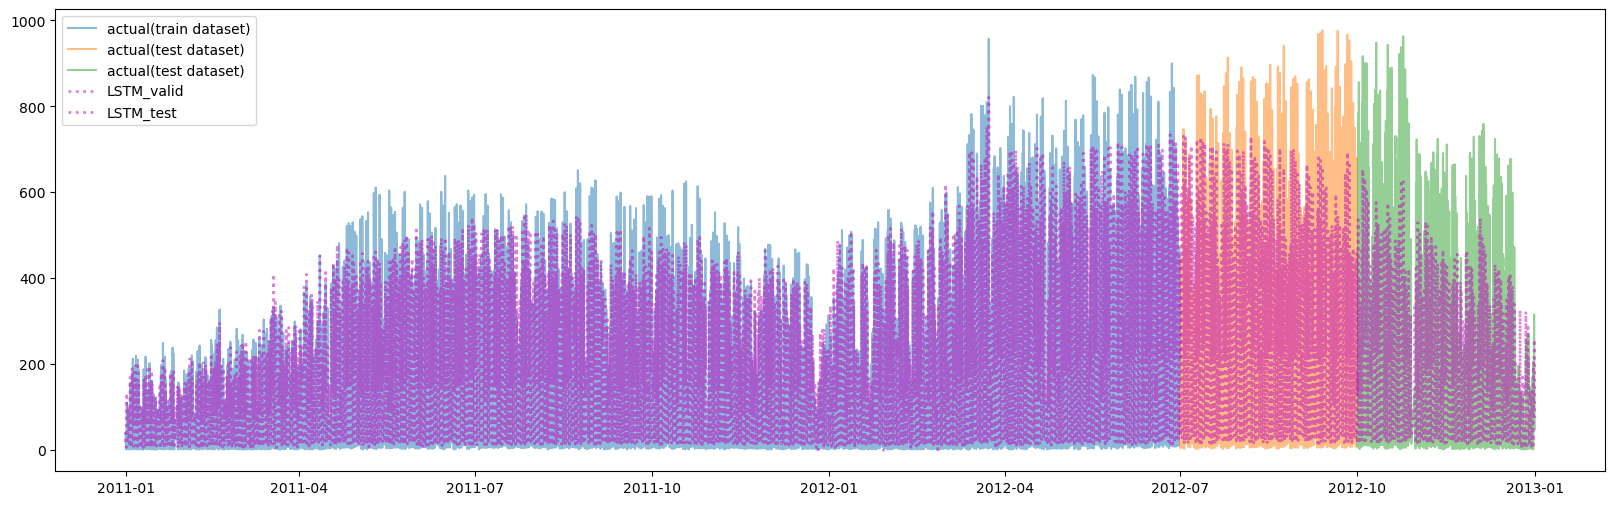

In [77]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y_train.index, y_train.values, label="actual(train dataset)", alpha = 0.5)
ax.plot(y_valid.index, y_valid.values, label="actual(test dataset)", alpha = 0.5)
ax.plot(y_test.index, y_test.values, label="actual(test dataset)", alpha = 0.5)

ax.plot(y_train.index, combined_result_train['cnt_pred'], linestyle="dotted", lw=2,color="m", alpha = 0.5)
ax.plot(y_valid.index, combined_result_valid['cnt_pred'], label="LSTM_valid", linestyle="dotted", lw=2, color="m", alpha = 0.5)
ax.plot(y_test.index, combined_result_test['cnt_pred'], label="LSTM_test", linestyle="dotted", lw=2, color="m", alpha = 0.5) 
plt.legend()

In [78]:
# predicted result
train_MAPE_lstm = mean_absolute_percentage_error(combined_result_train['cnt'], combined_result_train['cnt_pred'])
valid_MAPE_lstm = mean_absolute_percentage_error(combined_result_valid['cnt'], combined_result_valid['cnt_pred'])
test_MAPE_lstm = mean_absolute_percentage_error(combined_result_test['cnt'], combined_result_test['cnt_pred'])

print('train MAPE is {}'.format(train_MAPE_lstm))
print('valid MAPE is {}'.format(valid_MAPE_lstm))
print('test MAPE is {}'.format(test_MAPE_lstm))

train MAPE is 0.6792775151708926
valid MAPE is 0.4529603351409747
test MAPE is 0.6740810904952326


# Problem 5

## 5.1.	EXPLORATORY DATA ANALYSIS: CONDUCT A PRELIMINARY ANALYSIS OF THE DATASET. VISUALIZE THE DATA AND REPORT ANY OBSERVATIONS THAT MIGHT BE RELEVANT TO YOUR TASK. (5 POINTS)

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [8]:
train_data.describe()

,travel_mode,TrvlTime_number,Age,indiv_trvl_frequency,HHVeh,HHsize
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.789750,1044.952107,45.013750,28.658250,1.804000,3.695250
std,0.407537,1424.072973,14.929259,20.390105,0.910105,1.710733
min,0.000000,6.000000,16.000000,3.000000,0.000000,1.000000
25%,1.000000,340.078000,34.000000,15.000000,1.000000,2.000000
50%,1.000000,660.000000,44.000000,24.000000,2.000000,4.000000
75%,1.000000,1318.000000,56.000000,36.000000,2.000000,5.000000
max,1.000000,34350.000000,89.000000,192.000000,7.000000,13.000000


In [9]:
test_data.describe()

,travel_mode,TrvlTime_number,Age,indiv_trvl_frequency,HHVeh,HHsize
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.783000,1108.739891,44.355000,28.402000,1.767000,3.601000
std,0.412409,1667.569592,14.577087,22.071782,0.949533,1.677681
min,0.000000,19.999980,16.000000,3.000000,0.000000,1.000000
25%,1.000000,368.750000,33.000000,14.000000,1.000000,2.000000
50%,1.000000,699.008500,43.000000,22.000000,2.000000,4.000000
75%,1.000000,1370.890000,55.000000,35.250000,2.000000,5.000000
max,1.000000,37764.000000,94.000000,192.000000,7.000000,12.000000


Overall statistics looks very similar which indicates a successful random sampling between train and test dataset.

In [17]:
train_data.dtypes

travel_mode               int64
TrvlTime_number         float64
Age                       int64
indiv_trvl_frequency      int64
HHVeh                     int64
HHsize                    int64
dtype: object

All of the columns are numeric and thus we can feed the data to pca model without preprocessing other types of data such as object or datetime.

array([[<Axes: title={'center': 'travel_mode'}>,
        <Axes: title={'center': 'TrvlTime_number'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'indiv_trvl_frequency'}>],
       [<Axes: title={'center': 'HHVeh'}>,
        <Axes: title={'center': 'HHsize'}>]], dtype=object)

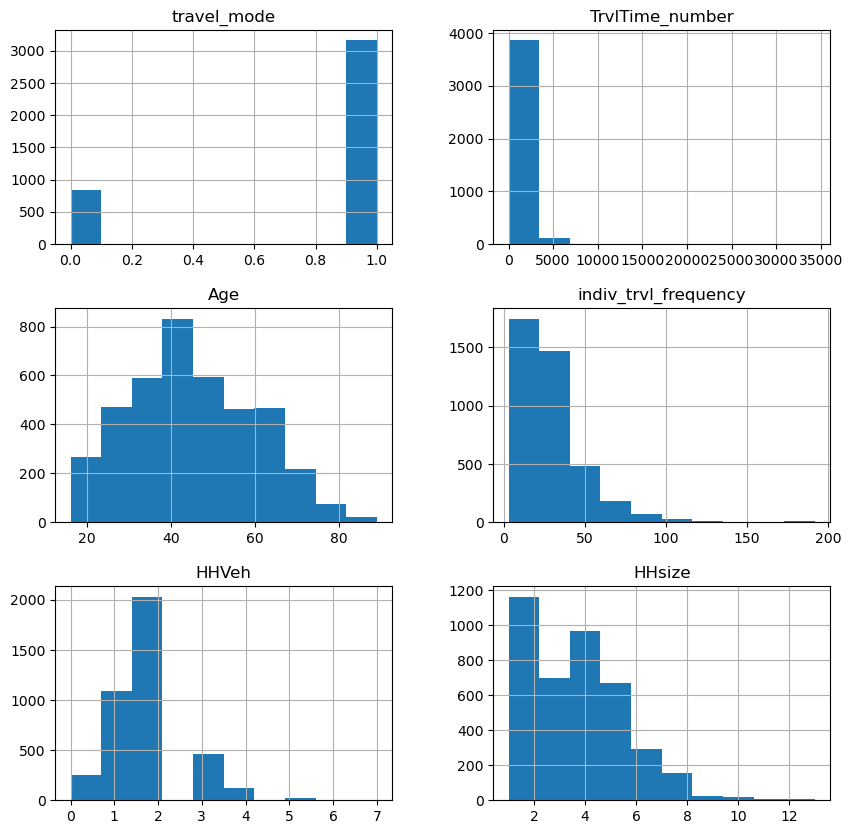

In [15]:
train_data.hist(figsize = (10,10))

There are reletively large gaps in scale of each variable.  Standardization would be necessary before conducting pca/clustering.

In [16]:
train_data.corr()

,travel_mode,TrvlTime_number,Age,indiv_trvl_frequency,HHVeh,HHsize
travel_mode,1.000000,0.158679,0.104993,0.233447,0.377664,0.005274
TrvlTime_number,0.158679,1.000000,0.022430,0.007686,0.108580,-0.034190
Age,0.104993,0.022430,1.000000,-0.004295,0.022688,-0.325799
indiv_trvl_frequency,0.233447,0.007686,-0.004295,1.000000,0.594961,0.185159
HHVeh,0.377664,0.108580,0.022688,0.594961,1.000000,0.180699
HHsize,0.005274,-0.034190,-0.325799,0.185159,0.180699,1.000000


There are a few autocorrelated variables such as Age and HHsize, or HHVeh and infiv_trvl_frequency.  <br>
This can be taken care of by conducting PCA before clustering.

## 5.2.	DATA PREPROCESSING: STANDARDIZE THE DATASET AND USE PRINCIPAL COMPONENT ANALYSIS (PCA) TO REDUCE THE DIMENSIONALITY OF THE DATASET (PLEASE NOMINATE AN APPROPRIATE NUMBER OF PRINCIPAL COMPONENTS TO REPRESENT AT LEAST 90% VARIATION IN THE DATA). NOTE THAT THE DATASET IS ALREADY SPLIT INTO A TRAINING SET AND A TEST SET. YOU SHOULD USE THEM DIRECTLY. (5 POINTS)

### 5.2.1. standardize the dataset

Introduce the standardize function which implements the following operations to the input dataframe(train_data or test_data)
- change the df shape so it only includes the columns with independent variables
- initiate StandardScaler and fit&transform the reshaped df
- convert back the standardized arrays into pandas df
- insert back the dependent variable (travel_mode) to the df
- return df

In [208]:
def standardize(df):
    df_stmd = df.drop('travel_mode', axis = 1)
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df_stmd)
    scaled_df = pd.DataFrame(scaled_df, columns = df_stmd.columns)
    scaled_df['travel_mode'] = df['travel_mode']
    scaled_df.insert(0, 'travel_mode', scaled_df.pop('travel_mode'))
    return scaled_df

apply standardize function to both data

In [59]:
train_data_std = standardize(train_data)
test_data_std = standardize(test_data)

check if the transformation was successful be looking at the head of df and look at mean and sd (whether they are around 0 and 1 respectively)

In [209]:
train_data_std.head(3)

,travel_mode,TrvlTime_number,Age,indiv_trvl_frequency,HHVeh,HHsize
0,0,-0.61661,0.066070,1.243001,1.314298,0.76278
1,1,-0.10180,0.133061,-0.228485,1.314298,0.76278
2,1,0.13347,-0.469858,-0.424683,0.215387,0.76278


In [61]:
train_data_std.describe()

,travel_mode,TrvlTime_number,Age,indiv_trvl_frequency,HHVeh,HHsize
count,4000.000000,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03
mean,0.789750,1.225686e-16,-1.065814e-16,6.217249e-17,-4.884981e-17,-1.332268e-17
std,0.407537,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00
min,0.000000,-7.296550e-01,-1.943658e+00,-1.258525e+00,-1.982437e+00,-1.575691e+00
25%,1.000000,-4.950324e-01,-7.378214e-01,-6.699307e-01,-8.835250e-01,-9.910731e-01
50%,1.000000,-2.703515e-01,-6.791206e-02,-2.284850e-01,2.153867e-01,1.781622e-01
75%,1.000000,1.917613e-01,7.359792e-01,3.601094e-01,2.153867e-01,7.627799e-01
max,1.000000,2.339010e+01,2.946680e+00,8.011836e+00,5.709945e+00,5.439721e+00


### 5.2.2. Reduce dimension using PCA

Introduce the standardize function which implements the following operations to the input dataframe(train_data_std or test_data_std)
1. conducting PCA
2. Calculate the variance ratio of each PC
3. Drawing screeplot to visualize 2.
4. calculate the contribution of each PC towards the original variables
5. calculate the predicted result per PC, draw histogram and return data in dataframe format.

In [217]:
def executePCA(df):
    # conduct PCA
    df_pca = df.drop('travel_mode', axis = 1)
    pca = PCA(n_components = df_pca.shape[1])
    pca.fit(df_pca)
    pca_pred = pca.transform(df_pca)

    # calculate the variance ratio of each PC
    variance_ratio = [round(variance_ratio, 5) for variance_ratio in pca.explained_variance_ratio_]
    print('variance_ratio of each PC:', variance_ratio)

    # scree plot
    plt.figure()
    plt.figure()
    plt.plot([0] + list(range(1, len(variance_ratio) + 1)), [0] + list(np.cumsum(pca.explained_variance_ratio_)))
    plt.hlines(y = 0.90, xmin = 0, xmax = len(variance_ratio) , color = 'r', linewidth = 0.7)
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.show()

    # contribution by PC
    contribution = pd.DataFrame(pca.components_)
    PCindex = ['PC' + str(i + 1) for i in range(df_pca.shape[1])]
    contribution.index = PCindex
    contribution.columns = [df_pca.columns[0:]]
    print(contribution)

    # predition
    pca_pred_df = pd.DataFrame(pca_pred,
                           columns = ["PC{}".format(x + 1) for x in range(len(df_pca.columns))]
                           )
    
    # draw histogram
    pca_pred_df.hist(figsize = (8,7))
    
    return pca_pred_df


Conduct PCA for train data

variance_ratio of each PC: [0.34276, 0.2539, 0.19762, 0.12658, 0.07914]


<Figure size 640x480 with 0 Axes>

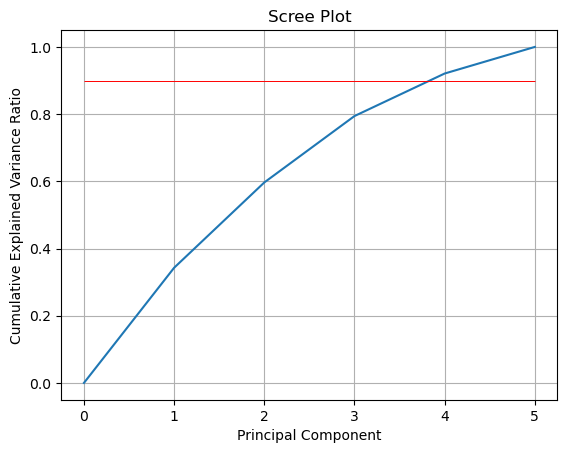

    TrvlTime_number       Age indiv_trvl_frequency     HHVeh    HHsize
PC1        0.079706 -0.161969             0.635794  0.637249  0.396350
PC2        0.246739  0.711544             0.221017  0.274890 -0.555349
PC3        0.956332 -0.218188            -0.183350 -0.028408  0.058308
PC4        0.062927  0.646430            -0.193496 -0.103336  0.728045
PC5        0.119319  0.044639             0.689826 -0.711944  0.032340


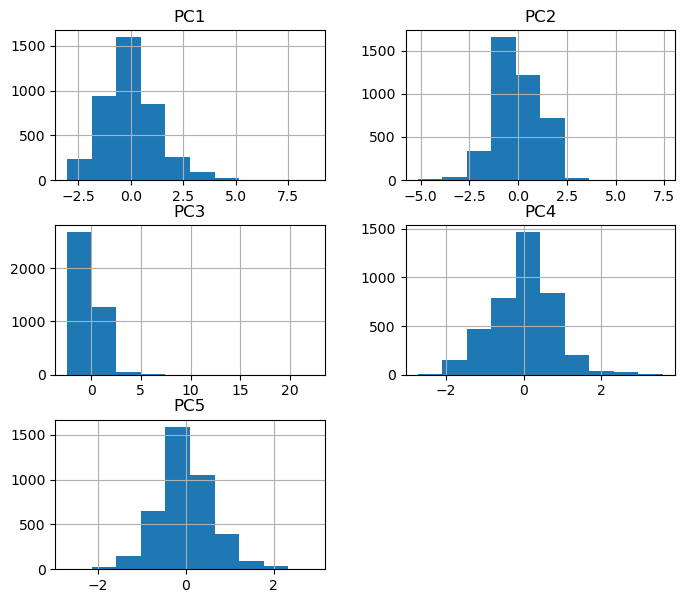

In [218]:
pca_pred_train = executePCA(train_data_std)

Possible interpretation of each PC:
- PC1: Frequent travelers who own more vehicles.
- PC2: Older people with small householdsize.
- PC3: Travelers who takes more time when traveling
- PC4: Older people with large householdsize.

In [102]:
pca_pred_train.head(2)

,PC1,PC2,PC3,PC4
0,1.870306,0.107272,-0.824864,0.182916
1,0.964927,-0.043260,-0.077355,0.543343


Drop PC5 as PC1 to PC4 together explains more than 90% of the variables.

In [99]:
pca_pred_train = pca_pred_train.drop('PC5', axis = 1)

sanity check with linear regression that PC1 - PC4 would be sufficient to explain the dependent variable.

In [100]:
reg = linear_model.LogisticRegression()
reg.fit(pca_pred_train, train_data['travel_mode'])
print('The estimated coefficients: ', reg.coef_)
print('The estimated intercept (e.g., $\beta_0$): ', reg.intercept_)
print('R^2 for test: %.2f' % reg.score(pca_pred_train, train_data['travel_mode']))

The estimated coefficients:  [[ 0.96639532  0.8831797   1.02343372 -0.00511068]]
The estimated intercept (e.g., eta_0$):  [1.93156002]
R^2 for test: 0.84


Conduct PCA for test data

variance_ratio of each PC: [0.35617, 0.25076, 0.19475, 0.13122, 0.06709]


<Figure size 640x480 with 0 Axes>

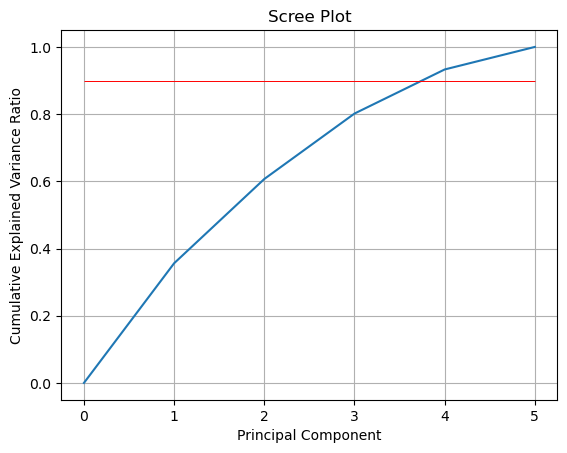

    TrvlTime_number       Age indiv_trvl_frequency     HHVeh    HHsize
PC1        0.009266 -0.017310             0.650959  0.660851  0.373018
PC2        0.326136  0.737277             0.150936  0.173725 -0.545066
PC3        0.942204 -0.248020            -0.117407 -0.012340  0.191836
PC4       -0.016801  0.625971            -0.263940 -0.130839  0.721869
PC5        0.074286  0.052636             0.685581 -0.718209  0.076582


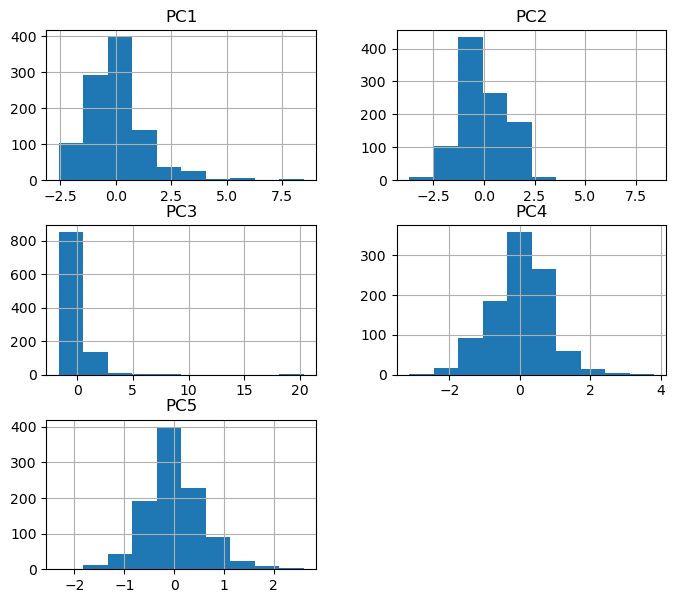

In [219]:
pca_pred_test = executePCA(test_data_std)

Drop PC5 as PC1 to PC4 together explains more than 90% of the variables.

In [93]:
pca_pred_test = pca_pred_test.drop('PC5', axis = 1)

In [98]:
reg = linear_model.LogisticRegression()
reg.fit(pca_pred_test, test_data['travel_mode'])
print('The estimated coefficients: ', reg.coef_)
print('The estimated intercept (e.g., $\beta_0$): ', reg.intercept_)
print('R^2 for test: %.2f' % reg.score(pca_pred_test, test_data['travel_mode']))

The estimated coefficients:  [[ 1.02581852  0.67808653  0.24311826 -0.22949893]]
The estimated intercept (e.g., eta_0$):  [1.77368572]
R^2 for test: 0.84


## 5.3.	MODEL BUILDING AND EVALUATION: IMPLEMENT THE CLUSTERING ALGORITHMS AND EVALUATE THEIR PERFORMANCE. YOU SHOULD REPORT THE ACCURACY AND PRECISION (FOR THE PREDICTION OF CAR MODE) OF EACH MODEL ON THE TEST SET. (5 POINTS)

## 5.3.1. K-means

Given the clustering result varies quite a lot for each run, I conduct each clustering for 40 runs and extract the one with the score (accurary + precision)

for trial data

In [275]:
# ignore warnings message
warnings.filterwarnings("ignore")

# Number of runs
n_runs = 40

# Initialize varaiables
best_kmeans = None
best_score = -1 

# Perform K-means multiple times and reserve the one with the highest accuracy
for _ in range(n_runs):
    kmeans = KMeans(n_clusters=2)
    kmeans_train_preds = kmeans.fit_predict(pca_pred_train)
    
    kmeans_accuracy = accuracy_score(train_data['travel_mode'], kmeans_train_preds)
    kmeans_precision = precision_score(train_data['travel_mode'], kmeans_train_preds)
    kmean_total_score =  kmeans_accuracy + kmeans_precision

    if  kmean_total_score > best_score:
        best_score = kmean_total_score
        best_kmeans = kmeans

# Predict with the best K-means model
kmeans_train_preds = best_kmeans.fit_predict(pca_pred_train)

for test data

In [276]:
kmeans_test_preds = best_kmeans.fit_predict(pca_pred_test)

store both results into one dataframe

In [277]:
kmean_train_df = pd.DataFrame({'y': train_data['travel_mode'],
                               'y_hat' : kmeans_train_preds})
kmean_test_df = pd.DataFrame({'y': test_data['travel_mode'],
                              'y_hat' : kmeans_test_preds}
                              )

Result - trial

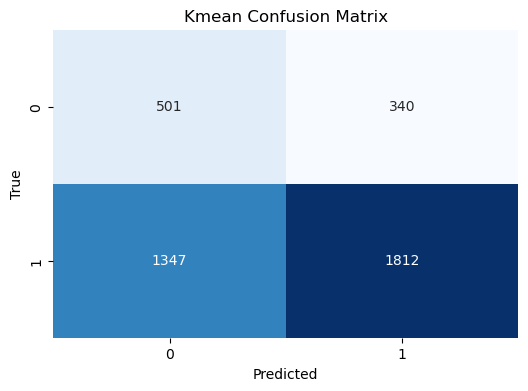

Accuracy: 0.58
Precision: 0.84


In [278]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(kmean_train_df['y'], kmean_train_df['y_hat'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Kmean Confusion Matrix')
plt.show()

# Evaluate K-means
kmeans_accuracy = accuracy_score(train_data['travel_mode'], kmeans_train_preds)
kmeans_precision = precision_score(train_data['travel_mode'], kmeans_train_preds)

print(f"Accuracy: {kmeans_accuracy:.2f}")
print(f"Precision: {kmeans_precision:.2f}")

Result - test

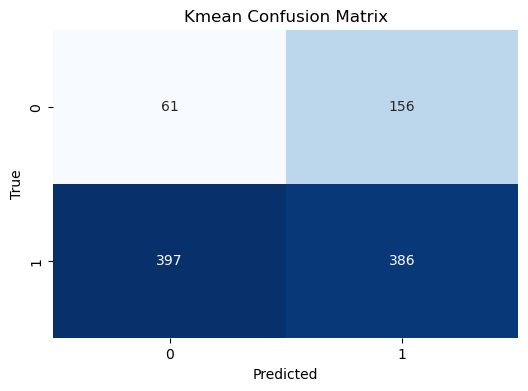

Accuracy: 0.45
Precision: 0.71


In [279]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(kmean_test_df['y'], kmean_test_df['y_hat'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Kmean Confusion Matrix')
plt.show()

# Evaluate K-means
kmeans_accuracy = accuracy_score(test_data['travel_mode'], kmeans_test_preds)
kmeans_precision = precision_score(test_data['travel_mode'], kmeans_test_preds)

print(f"Accuracy: {kmeans_accuracy:.2f}")
print(f"Precision: {kmeans_precision:.2f}")

## 5.3.2. Gaussian Mixture

Given the clustering result varies quite a lot for each run, I conduct each clustering for 40 runs and extract the one with the best accuracy.

for trial data

In [290]:
# Initialize varaiables
best_gmm = None
best_score = -1 

# Perform K-means multiple times and reserve the one with the highest accuracy
for _ in range(n_runs):
    gmm = GaussianMixture(n_components=2)
    gmm_train_preds = gmm.fit_predict(pca_pred_train)
    
    gmm_accuracy = accuracy_score(train_data['travel_mode'], gmm_train_preds)
    gmm_precision = precision_score(train_data['travel_mode'], kmeans_train_preds)
    gmm_total_score =  gmm_accuracy + gmm_precision
    
    if  gmm_total_score > best_score:
        best_score = gmm_total_score
        best_gmm = gmm

# Predict with the best K-means model
gmm_train_preds = best_gmm.fit_predict(pca_pred_train)

for test data

In [291]:
gmm_test_preds = best_gmm.fit_predict(pca_pred_test)

In [292]:
gmm_train_df = pd.DataFrame({'y': train_data['travel_mode'],
                             'y_hat' : gmm_train_preds})
gmm_test_df = pd.DataFrame({'y': test_data['travel_mode'],
                            'y_hat' : gmm_test_preds})

Result - trial

Accuracy: 0.57
Precision: 0.76


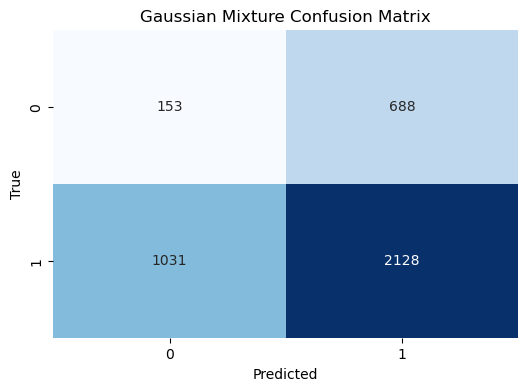

In [293]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(gmm_train_df['y'], gmm_train_df['y_hat'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gaussian Mixture Confusion Matrix')
plt.show

# Evaluate K-means
gmm_accuracy = accuracy_score(train_data['travel_mode'], gmm_train_preds)
gmm_precision = precision_score(train_data['travel_mode'], gmm_train_preds)

print(f"Accuracy: {gmm_accuracy:.2f}")
print(f"Precision: {gmm_precision:.2f}")

Result -test

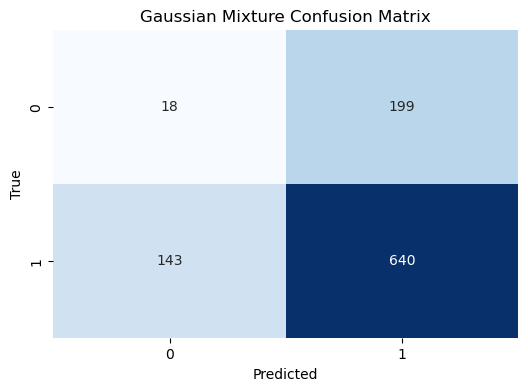

Accuracy: 0.66
Precision: 0.76


In [294]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(gmm_test_df['y'], gmm_test_df['y_hat'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gaussian Mixture Confusion Matrix')
plt.show()

# Evaluate K-means
gmm_accuracy = accuracy_score(test_data['travel_mode'], gmm_test_preds)
gmm_precision = precision_score(test_data['travel_mode'], gmm_test_preds)

print(f"Accuracy: {gmm_accuracy:.2f}")
print(f"Precision: {gmm_precision:.2f}")